In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import pyplot
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam




In [2]:
AMZN_dataset = pd.read_csv('../datasets/AMZN.csv', parse_dates=['Date'])
MSFT_dataset = pd.read_csv('../datasets/MSFT.csv', parse_dates=['Date'])
GOOG_dataset = pd.read_csv('../datasets/GOOG.csv', parse_dates=['Date'])




In [3]:
AMZN_dataset.replace(0, np.nan, inplace=True)
AMZN_dataset.to_csv("../datasets/AMZN.csv", index=False)

MSFT_dataset.replace(0, np.nan, inplace=True)
MSFT_dataset.to_csv("../datasets/MSFT.csv", index=False)

GOOG_dataset.replace(0, np.nan, inplace=True)
GOOG_dataset.to_csv("../datasets/GOOG.csv", index=False)

In [4]:
datetime_series = pd.to_datetime(AMZN_dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
AMZN_dataset = AMZN_dataset.set_index(datetime_index)
AMZN_dataset = AMZN_dataset.sort_values(by='Date')
AMZN_dataset = AMZN_dataset.drop(columns='Date')

datetime_series = pd.to_datetime(MSFT_dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
MSFT_dataset = MSFT_dataset.set_index(datetime_index)
MSFT_dataset = MSFT_dataset.sort_values(by='Date')
MSFT_dataset = MSFT_dataset.drop(columns='Date')

datetime_series = pd.to_datetime(GOOG_dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
GOOG_dataset = GOOG_dataset.set_index(datetime_index)
GOOG_dataset = GOOG_dataset.sort_values(by='Date')
GOOG_dataset = GOOG_dataset.drop(columns='Date')



In [5]:
AMZN_X_value = pd.DataFrame(AMZN_dataset.iloc[:, :])
AMZN_y_value = pd.DataFrame(AMZN_dataset.iloc[:, 3])

MSFT_X_value = pd.DataFrame(MSFT_dataset.iloc[:, :])
MSFT_y_value = pd.DataFrame(MSFT_dataset.iloc[:, 3])

GOOG_X_value = pd.DataFrame(GOOG_dataset.iloc[:, :])
GOOG_y_value = pd.DataFrame(GOOG_dataset.iloc[:, 3])


In [6]:
GOOG_X_value

,Open,High,Low,Close,Adj Close,Volume
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.724083,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.521841,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.828691,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.365179,102486711
2014-01-08,28.543015,28.575891,28.226450,28.424210,28.424210,90036218
...,...,...,...,...,...,...
2024-04-05,151.679993,154.839996,151.080994,153.940002,153.940002,16289800
2024-04-08,154.014999,156.654999,153.990005,156.139999,156.139999,16641500
2024-04-09,157.350006,159.889999,156.639999,158.139999,158.139999,21538100
2024-04-10,157.880005,158.160004,156.199997,157.660004,157.660004,16339200


In [7]:
GOOG_y_value

,Close
2014-01-02,27.724083
2014-01-03,27.521841
2014-01-06,27.828691
2014-01-07,28.365179
2014-01-08,28.424210
...,...
2024-04-05,153.940002
2024-04-08,156.139999
2024-04-09,158.139999
2024-04-10,157.660004


In [8]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))


In [9]:
X_scaler.fit(AMZN_X_value)
y_scaler.fit(AMZN_y_value)

AMZN_X_scale_dataset = X_scaler.fit_transform(AMZN_X_value)
AMZN_y_scale_dataset = y_scaler.fit_transform(AMZN_y_value)

In [10]:
X_scaler.fit(MSFT_X_value)
y_scaler.fit(MSFT_y_value)

MSFT_X_scale_dataset = X_scaler.fit_transform(MSFT_X_value)
MSFT_y_scale_dataset = y_scaler.fit_transform(MSFT_y_value)

In [11]:
X_scaler.fit(GOOG_X_value)
y_scaler.fit(GOOG_y_value)

GOOG_X_scale_dataset = X_scaler.fit_transform(GOOG_X_value)
GOOG_y_scale_dataset = y_scaler.fit_transform(GOOG_y_value)

In [12]:
n_steps_in = 3
n_features = AMZN_X_value.shape[1]
n_steps_out = 1

In [13]:
print(n_steps_in)
print(n_features)
print(n_steps_out)

3
6
1


In [14]:
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

In [15]:
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

In [16]:
def split_train_test(data):
    train_size = round(len(data) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [17]:
AMZN_X,  AMZN_y,  AMZN_yc = get_X_y(AMZN_X_scale_dataset, AMZN_y_scale_dataset)
AMZN_X_train,  AMZN_X_test  =  split_train_test(AMZN_X)
AMZN_y_train, AMZN_y_test  =  split_train_test(AMZN_y)
AMZN_yc_train, AMZN_yc_test, = split_train_test(AMZN_yc)
AMZN_index_train, AMZN_index_test, = predict_index(AMZN_dataset, AMZN_X_train, n_steps_in, n_steps_out)

In [18]:
MSFT_X,  MSFT_y,  MSFT_yc = get_X_y(MSFT_X_scale_dataset, MSFT_y_scale_dataset)
MSFT_X_train,  MSFT_X_test  =  split_train_test(MSFT_X)
MSFT_y_train, MSFT_y_test  =  split_train_test(MSFT_y)
MSFT_yc_train, MSFT_yc_test, = split_train_test(MSFT_yc)
MSFT_index_train, MSFT_index_test, = predict_index(MSFT_dataset, MSFT_X_train, n_steps_in, n_steps_out)

In [19]:
GOOG_X,  GOOG_y,  GOOG_yc = get_X_y(GOOG_X_scale_dataset, GOOG_y_scale_dataset)
GOOG_X_train,  GOOG_X_test  =  split_train_test(GOOG_X)
GOOG_y_train, GOOG_y_test  =  split_train_test(GOOG_y)
GOOG_yc_train, GOOG_yc_test, = split_train_test(GOOG_yc)
GOOG_index_train, GOOG_index_test, = predict_index(GOOG_dataset, GOOG_X_train, n_steps_in, n_steps_out)

In [20]:
LR = 0.0001
BATCH_SIZE = 128
N_EPOCH = 180

In [21]:
input_dim = AMZN_X_train.shape[1]
feature_size = AMZN_X_train.shape[2]
output_dim = AMZN_y_train.shape[1]

In [22]:
def model_LSTM(input_dim, output_dim , feature_size, X_train , y_train):
    model = Sequential()
    model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE,
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()

    return model

Epoch 1/180
15/15 - 8s - loss: 0.1956 - 8s/epoch - 518ms/step
Epoch 2/180
15/15 - 0s - loss: 0.0169 - 205ms/epoch - 14ms/step
Epoch 3/180
15/15 - 0s - loss: 0.0080 - 200ms/epoch - 13ms/step
Epoch 4/180
15/15 - 0s - loss: 0.0130 - 201ms/epoch - 13ms/step
Epoch 5/180
15/15 - 0s - loss: 0.0213 - 216ms/epoch - 14ms/step
Epoch 6/180
15/15 - 0s - loss: 0.0345 - 221ms/epoch - 15ms/step
Epoch 7/180
15/15 - 0s - loss: 0.0338 - 226ms/epoch - 15ms/step
Epoch 8/180
15/15 - 0s - loss: 0.0326 - 230ms/epoch - 15ms/step
Epoch 9/180
15/15 - 0s - loss: 0.0369 - 218ms/epoch - 15ms/step
Epoch 10/180
15/15 - 0s - loss: 0.0246 - 207ms/epoch - 14ms/step
Epoch 11/180
15/15 - 0s - loss: 0.0283 - 196ms/epoch - 13ms/step
Epoch 12/180
15/15 - 0s - loss: 0.0152 - 199ms/epoch - 13ms/step
Epoch 13/180
15/15 - 0s - loss: 0.0160 - 199ms/epoch - 13ms/step
Epoch 14/180
15/15 - 0s - loss: 0.0073 - 196ms/epoch - 13ms/step
Epoch 15/180
15/15 - 0s - loss: 0.0079 - 189ms/epoch - 13ms/step
Epoch 16/180
15/15 - 0s - loss: 0.00

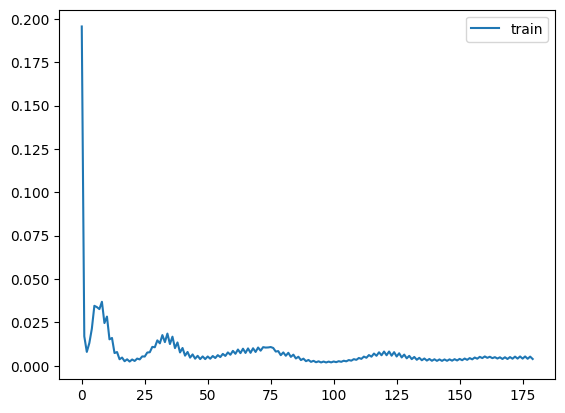

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               138240    
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 154753 (604.50 KB)
Trainable params: 154753 (604.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
[[ 5.35502255e-01]
 [ 5.35069287e-01]
 [ 5.41066945e-01]
 [ 5.36916137e-01]
 [ 5.32191277e-01]
 [ 5.30587018e-01]
 [ 5.43777347e-01]
 [ 5.49398065e-01]
 [ 5.44573247e-01]
 [ 5.28899133e-01]
 [ 5.23163736e-01]


In [23]:
model = model_LSTM(input_dim, output_dim, feature_size , AMZN_X_train , AMZN_y_train)
print(model.summary())

yhat = model.predict(AMZN_X_test, verbose=0)
print(yhat)

rmse = sqrt(mean_squared_error(AMZN_y_test, yhat))
print(rmse)

In [24]:
def plot_traindataset_result(X_train, y_train,train_index):
    train_yhat = model.predict(X_train, verbose=0)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index= train_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Train", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Train RMSE -- ', RMSE)

    return RMSE


C:\Users\cs20b\AppData\Local\Temp\ipykernel_24616\2882637674.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
C:\Users\cs20b\AppData\Local\Temp\ipykernel_24616\2882637674.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


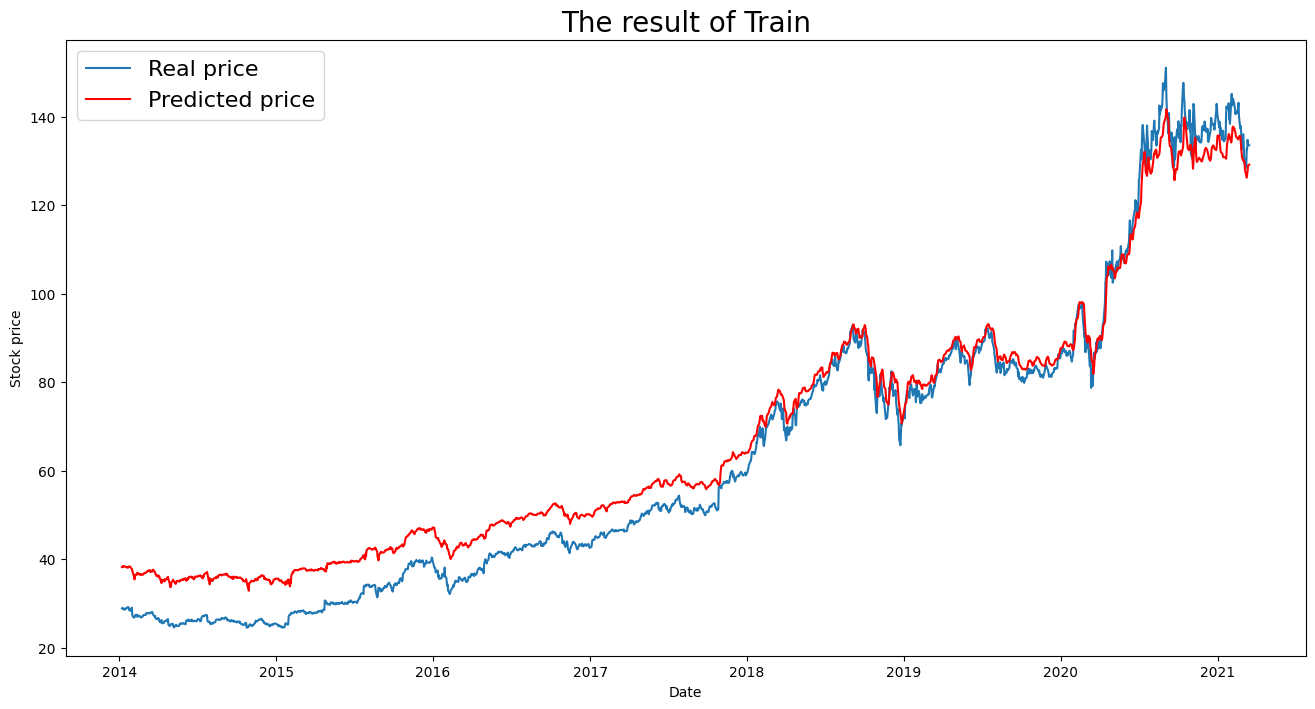

GRU Training set RMSE :  6.3745194878666345


In [25]:
train_RMSE = plot_traindataset_result(AMZN_X_train, AMZN_y_train , AMZN_index_train)
print("GRU Training set RMSE : ", train_RMSE)

In [26]:
def plot_testdataset_result(X_test, y_test , test_index):

    test_yhat = model.predict(X_test, verbose=0)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2024-02-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE -- ', RMSE)

    return RMSE

C:\Users\cs20b\AppData\Local\Temp\ipykernel_24616\2882637674.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
C:\Users\cs20b\AppData\Local\Temp\ipykernel_24616\2882637674.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


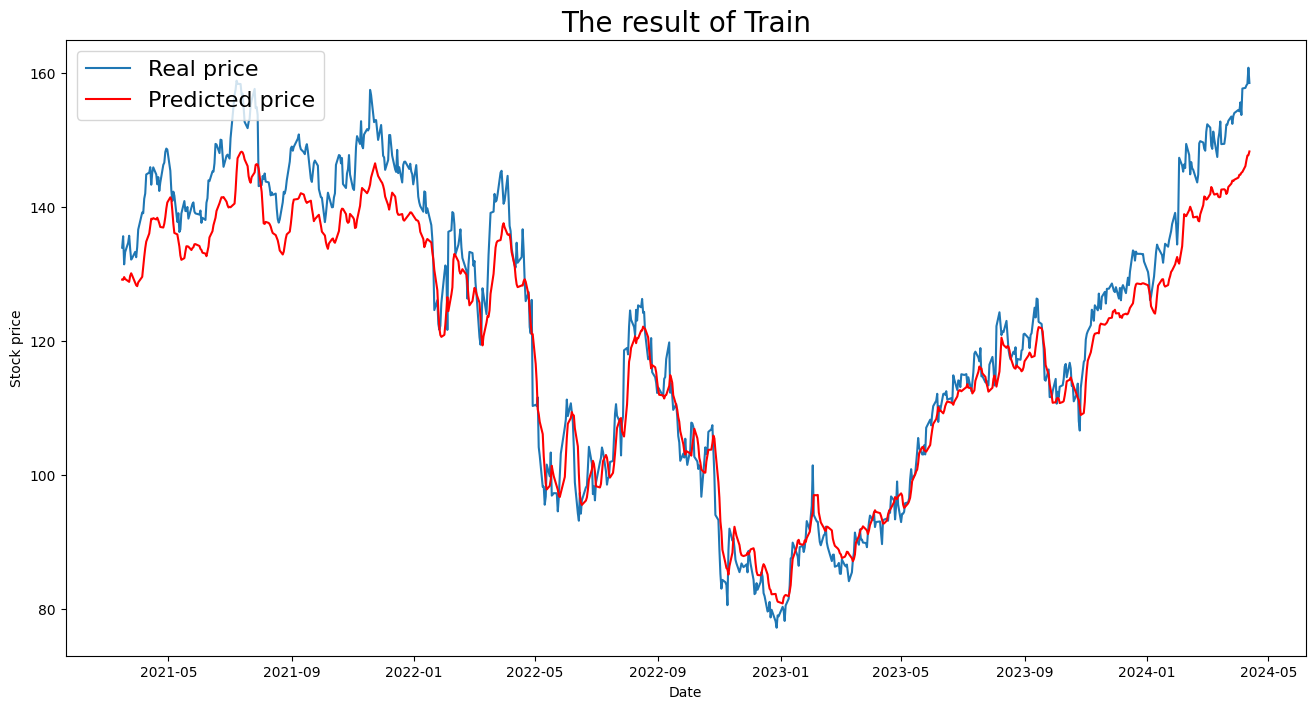

GRU Test set RMSE :  5.581866061914365


In [27]:
test_RMSE = plot_traindataset_result(AMZN_X_test, AMZN_y_test, AMZN_index_test)
print("GRU Test set RMSE : ", test_RMSE)

In [ ]:
model = model_LSTM(input_dim, output_dim, feature_size , MSFT_X_train , MSFT_y_train)
print(model.summary())

yhat = model.predict(MSFT_X_test, verbose=0)
print(yhat)

rmse = sqrt(mean_squared_error(MSFT_y_test, yhat))
print(rmse)

In [ ]:
train_RMSE = plot_traindataset_result(MSFT_X_train, MSFT_y_train , MSFT_index_train)
print("GRU Training set RMSE : ", train_RMSE)

In [ ]:
test_RMSE = plot_traindataset_result(MSFT_X_test, MSFT_y_test, MSFT_index_test)
print("GRU Test set RMSE : ", test_RMSE)

In [ ]:
model = model_LSTM(input_dim, output_dim, feature_size , GOOG_X_train , GOOG_y_train)
print(model.summary())

yhat = model.predict(GOOG_X_test, verbose=0)
print(yhat)

rmse = sqrt(mean_squared_error(GOOG_y_test, yhat))
print(rmse)

In [ ]:
train_RMSE = plot_traindataset_result(GOOG_X_train, GOOG_y_train , GOOG_index_train)
print("GRU Training set RMSE : ", train_RMSE)

In [ ]:
print("GRU Test set RMSE : ", test_RMSE)
